# Basic Image Segmentation with Python (not AI)

### We'll look at how to do some basic image manipulation

### by chaining many things together, we can make baby steps towards proper image analysis 

##### This first cell performs our setup - imports libraries, specifies our starting image & makes some helper functions


In [18]:
# !pip install numpy scikit-image scipy matplotlib

import numpy as np

# Plotting library
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Image manipulation
import numpy as np
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from scipy.ndimage import binary_fill_holes
from PIL import Image, ImageOps


img_file = 'l-spine.jpg'


def show(img):
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')

def show_colour(img):
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img)


def show_hist(img):
    min = img.min()
    max = img.max()
    rangebyten = 0.1 * (max - min)

    fig, ax = plt.subplots(1, 1)
    ax.hist(img.ravel(), bins=256, range=[min - rangebyten, max + rangebyten])
    ax.set_xlim(min, max);

def show_hist_labels(img):
    fig, ax = plt.subplots(1, 1)
    ax.hist(img.ravel(), bins=256, range=(1, img.max()))
    ax.set_xlim(img.min(), img.max());


### Lets use the Pillow library to load the image

##### We can display the image just by entering the name of the object - in this case `pil_img`

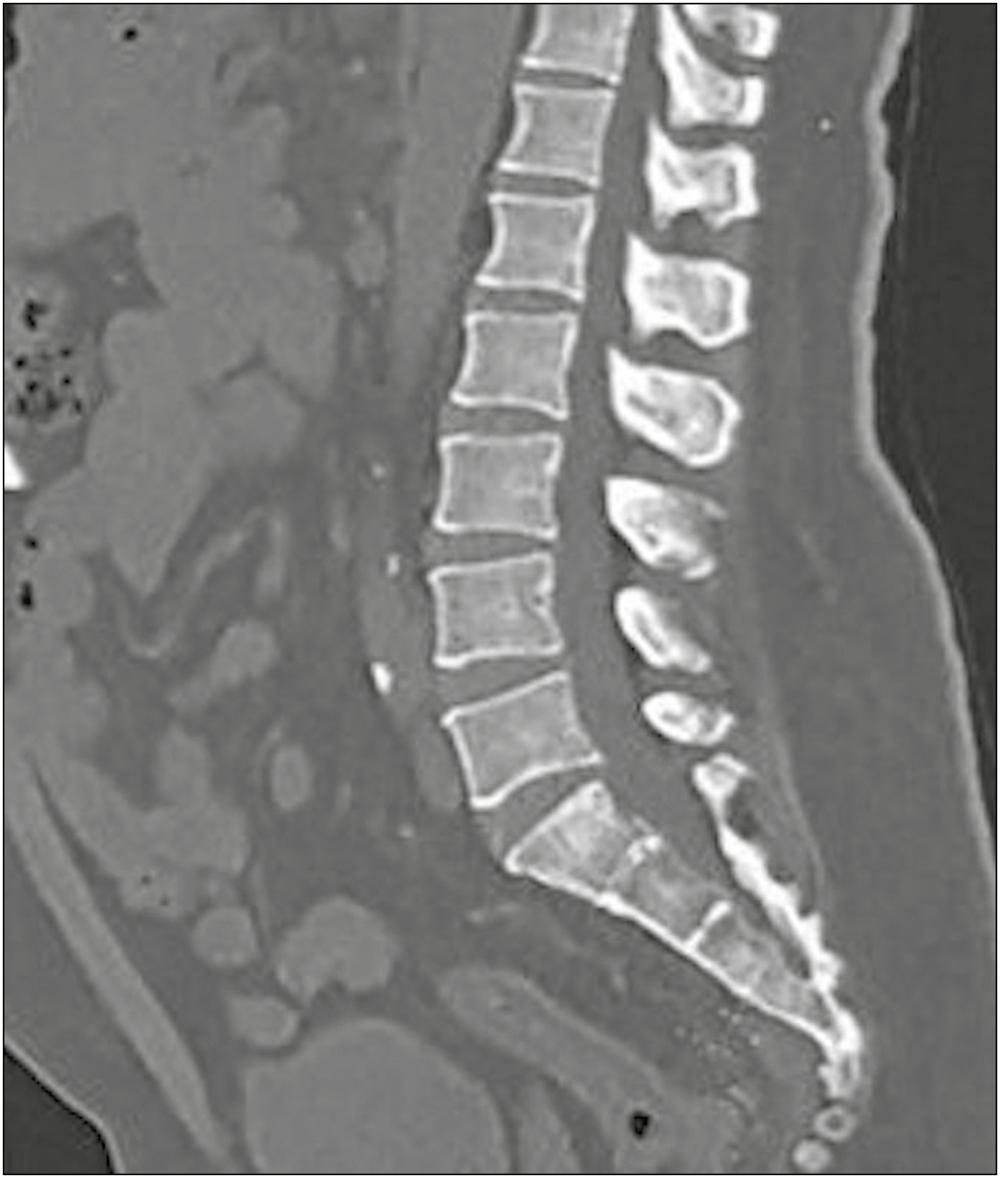

In [19]:
pil_img = Image.open(img_file)
pil_img



### For our ease, we convert the Pillow object into a more flexible number array (a Numpy array)

##### At the same time, we need to convert the RGB (3 channel) image into a single channel greyscale image

Image size: (1177, 1000)


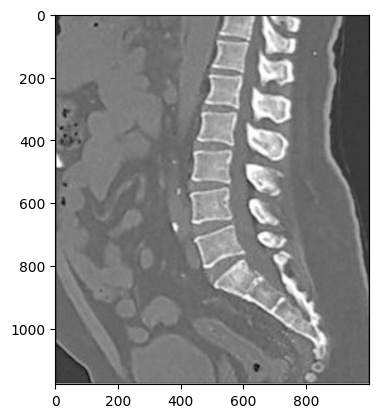

In [20]:
# Load image and convert to a Numpy array
grey_img = ImageOps.grayscale(pil_img)
grey_img = np.array(grey_img)

# Print out the image size in pixels
print(f'Image size: {grey_img.shape}')

# Display the image
show(grey_img)

### We can inspect what our greyscale image actually is - just an array of numbers from 0 to 255

In [21]:
grey_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 254, ..., 255, 255, 255],
       [255, 255, 243, ..., 241, 255, 255],
       ...,
       [254, 255, 203, ..., 197, 255, 255],
       [255, 255, 242, ..., 241, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

#### To segment the image, we want to maximise contrast to help.

#### We can threshold the image- everything below a certain value can be set to 0, and above to 1

#### But what should the value be?  Displaying a histogram can help us here

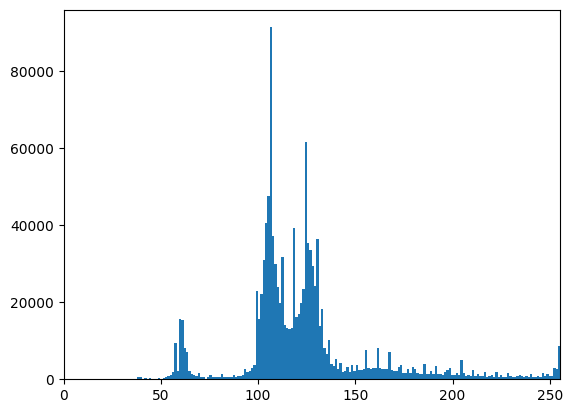

In [22]:
show_hist(grey_img)


### It isn't obvious where we should set the threshold value...  Let's guess

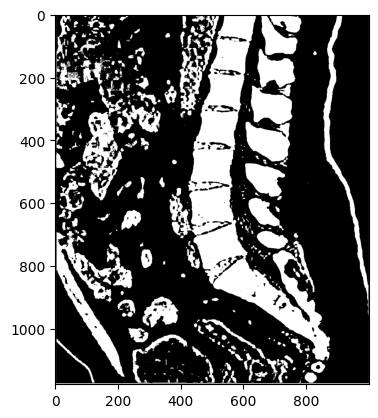

In [23]:
# let's guess - somewhere between 0 and 255
value = 128

# make a copy to mess with
test = grey_img.copy()

test[test < value] = 0
test[test >= value] = 1

show(test)


### Guessing is hard.

#### Let's let the computer do it for us.

#### the Otsu algorithm will show us how it's done.

In [24]:
# Import the Ostu threshold filter
from skimage.filters import threshold_otsu

threshold = threshold_otsu(grey_img)

print(threshold)
# t_bw[t_bw < thresholded] = 0
# t_bw[t_bw > 0] = 1
# t_bw = morphology.remove_small_holes(t_bw.astype(bool), 1000)

# show(t_bw)

152


### That's the suggested threshold value - let's have a look

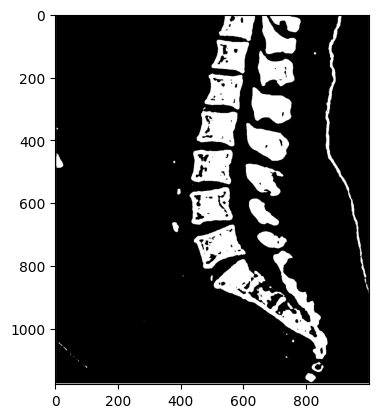

In [25]:
# Set all values < threshold to 0
# Set all values >= threshold to 1

# Looks confusing but in each pixel where the value of the grey_img is above threshold, t_img will be True (==1)
# And will otherwise be False (==0)
t_img = grey_img >= threshold

show(t_img)


### Let's try to clean up the image a bit more. There are a lot of holes

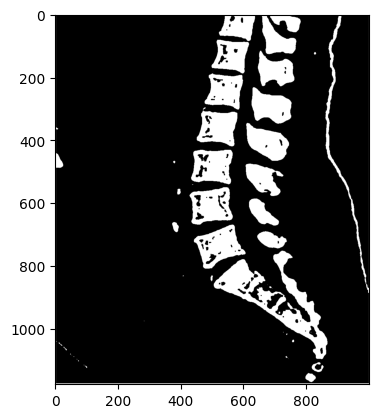

In [26]:
# Try different values - what does this do when larger? e.g. 15
close_factor = 3

closed_img = closing(t_img, square(close_factor))
show(closed_img)


### Some effect but could be better.

#### Let's try the binary_fill_holes algorithm

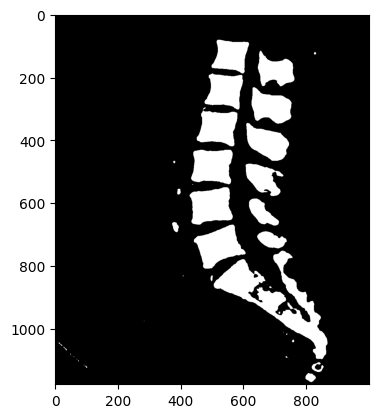

In [27]:
# First clear the edge so the algo knows what is 'outside' - working with the thresholded image
cleared_img = clear_border(closed_img)

# Now apply the binary fill algo
filled_img = binary_fill_holes(cleared_img.astype(bool), structure=np.ones((3,3))).astype(int)

show(filled_img)

### This image is now 'filled'.  Now to separately identify each connected block of pixels

In [28]:
# label image regions
label_image = label(filled_img)

#### Let's try to see what just happened

Unique values in label_image: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]


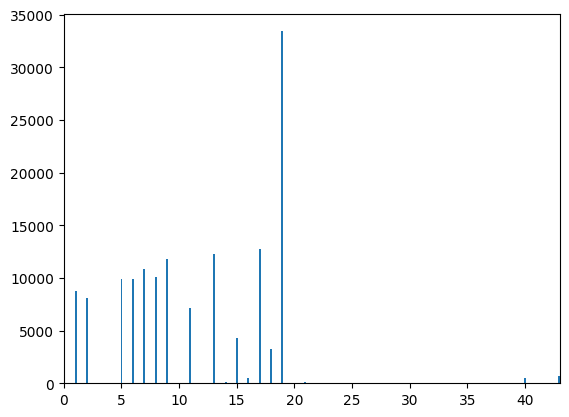

In [29]:
# list out the individual values
print(f'Unique values in label_image: {np.unique(label_image)}')

# Histogram the values (but hiding the 0 bar which is too high to be useful)
show_hist_labels(label_image)

### Let's make each different number a different colour to better show the difference

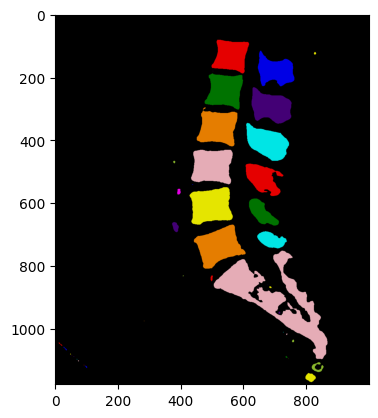

In [30]:
image_label_overlay = label2rgb(label_image, image=filled_img, bg_label=0)

show(image_label_overlay * 3)
#      the * 3 just makes the colours brighter

### Let's show that on the original image


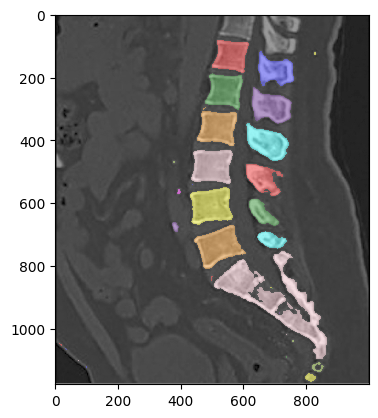

In [31]:
plt.figure()
plt.imshow(grey_img, 'gray', interpolation='none')
plt.imshow(image_label_overlay * 3, interpolation='none', alpha=0.4)
plt.show()

### And finally with a few bells and whistles

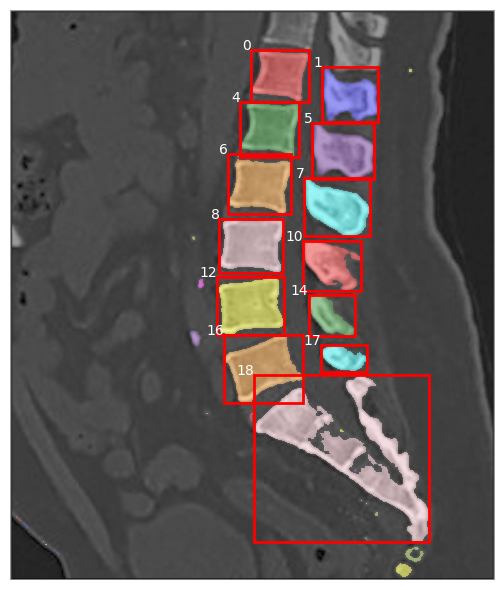

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.imshow(grey_img, cmap='gray')
ax.imshow(image_label_overlay * 3, interpolation='none', alpha=0.4)

# Do some extra markup

for i, region in enumerate(regionprops(label_image)):
    # take only regions with large enough areas
    # print(f'{i}: {region.area}')
    if region.area >= 650:
        # Label number, and draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(minc, minr, i, color='white', horizontalalignment='right')

ax.set_axis_off()
plt.tight_layout()
plt.show()


### This is the raw code without fuss

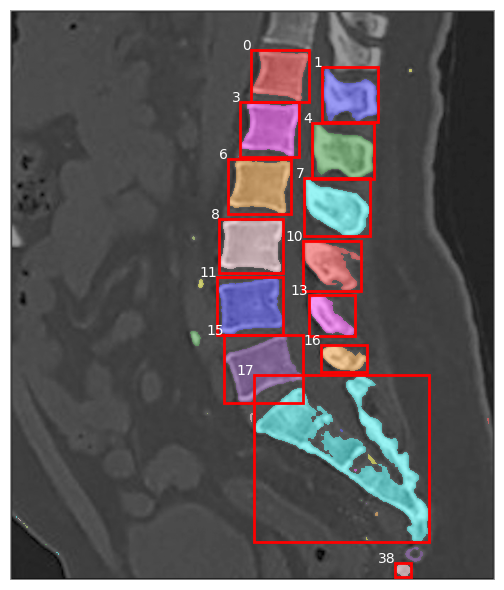

In [33]:
# Adapted from:
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from scipy.ndimage import binary_fill_holes
from PIL import Image, ImageOps

img_file = 'l-spine.jpg'
p_img = Image.open(img_file)
greyscale = ImageOps.grayscale(p_img)

image = np.asarray(greyscale)
thresholded = threshold_otsu(image)
bw = closing(image > thresholded, square(3))
cleared = clear_border(bw)

filled = binary_fill_holes(cleared.astype(bool), structure=np.ones((3,3))).astype(int)

# label image regions
label_image = label(filled)
image_label_overlay = label2rgb(label_image, image=filled, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.imshow(greyscale, cmap='gray')
ax.imshow(image_label_overlay * 3, interpolation='none', alpha=0.4)

for i, region in enumerate(regionprops(label_image)):
    if region.area >= 500:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(minc, minr, i, color='white', horizontalalignment='right')

ax.set_axis_off()
plt.tight_layout()
plt.show()


### From here we can select any of these and analyse it separately

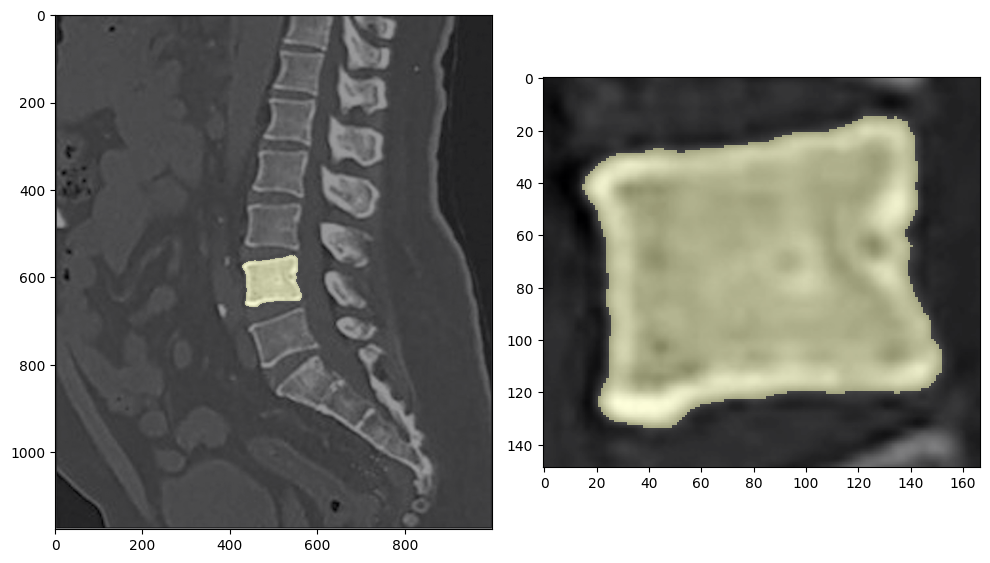

In [34]:
# for example label 6
label_no = 11
border = 15

regions = regionprops(label_image)  # List of all the labelled regions 

minr, minc, maxr, maxc = regions[label_no].bbox  # Bounding Box sides

# Select out ONLY the label number we want
label_mask = (label_image == (label_no+1)).astype(np.uint)

# Zoom into the image to centre on the region we want
subregion_mask = label_mask[minr - border: maxr + border, minc - border: maxc + border]
subregion_orig = image[minr - border: maxr + border, minc - border: maxc + border]

# Draw the images below 
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(image, cmap='gray')
ax[0].imshow(label_mask * 0.9, interpolation='none', alpha=0.4, cmap='inferno')
ax[1].imshow(subregion_orig, cmap='gray')
ax[1].imshow(subregion_mask * 0.9, interpolation='none', alpha=0.4, cmap='inferno')
plt.tight_layout()
plt.show()

## From here you can perform more detailed analysis on each segmented item

And certainly generate some pretty pictures...